Giovanni BENEDETTI DA ROSA


In [146]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
import scipy.fftpack as sff

**I - Data generation and manipulation**

The objective of this first short part is to create some datasets to get accustomed to them. It will enable us to :
- recall the notion of sparsity ;
- geometrically understand the effect of the mixing.

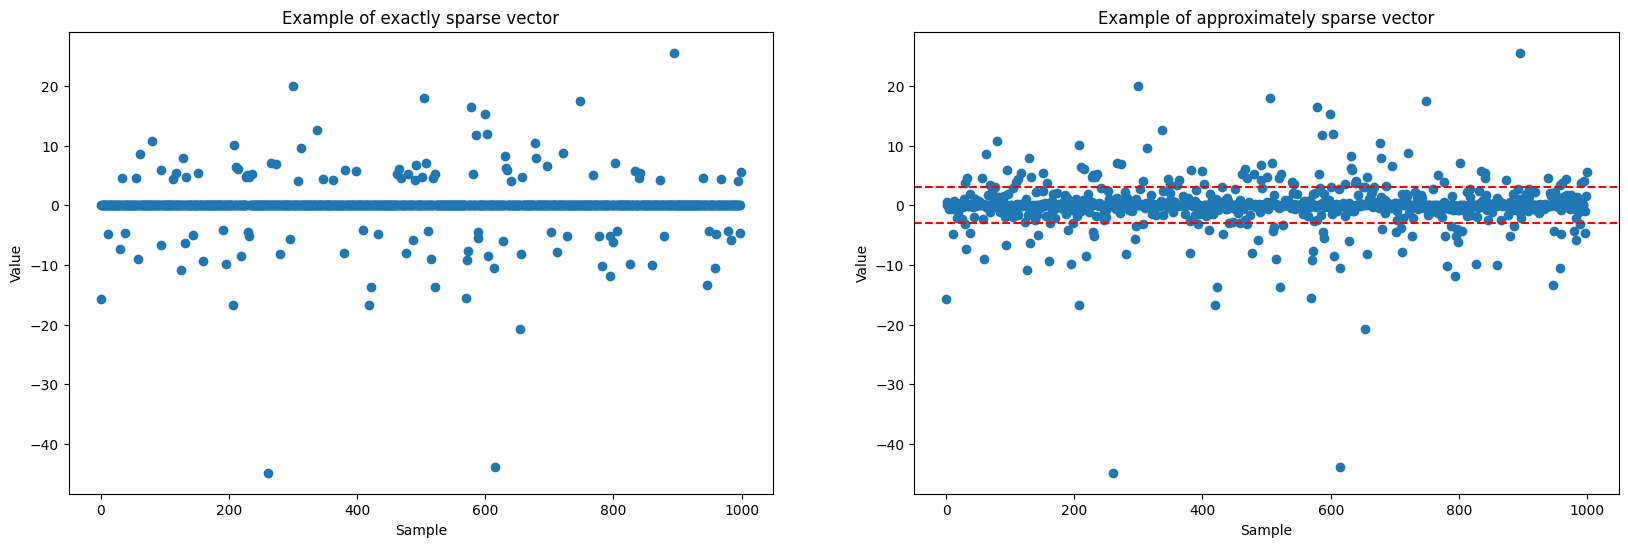

In [147]:
power = 3
approx_sparse = np.random.randn(1000)**power
exact_sparse = approx_sparse*(np.abs(approx_sparse)>4)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.plot(exact_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of exactly sparse vector');

fig.add_subplot(1,2,2)
plt.plot(approx_sparse, 'o')
plt.axhline(y=3, color='r', linestyle='--')
plt.axhline(y=-3, color='r', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of approximately sparse vector');

What is the difference between an exactly and an approximately sparse signal? Recall the two corresponding definitions.



**Answer:**

Sparsity amounts to represent a signal with as few variables as possible.

**Exact sparsity**: An exactly sparse signal is a signal that can be represented using only a small number of non-zero coefficients in a particular basis. A signal $s \in R ^ {n}$ is said to be k-sparse if only $k << t$ of its elements are non-zeros. $ ||s||_0 = k << t $, with the pseudo-norm $∥.∥_0$ being the cardinal of the support of of s.



**Approximate sparsity**:An approximately sparse signal is a signal that can be approximated using a small number of coefficients, that have non negligible values in a particular basis. Which means that just a k-sparse signals are enough to approximate the signal, with some residual errors. $ ||s||_0 = k \approx t $. The majority of the real signals are like this.

Now let's start to look at some mixtures and to try to geometrically interpret the impact of the mixing.

First, generate a simulated source S matrix. Plot the corresponding scatter plot. Interpret the shape of the scatter plot you obtain.

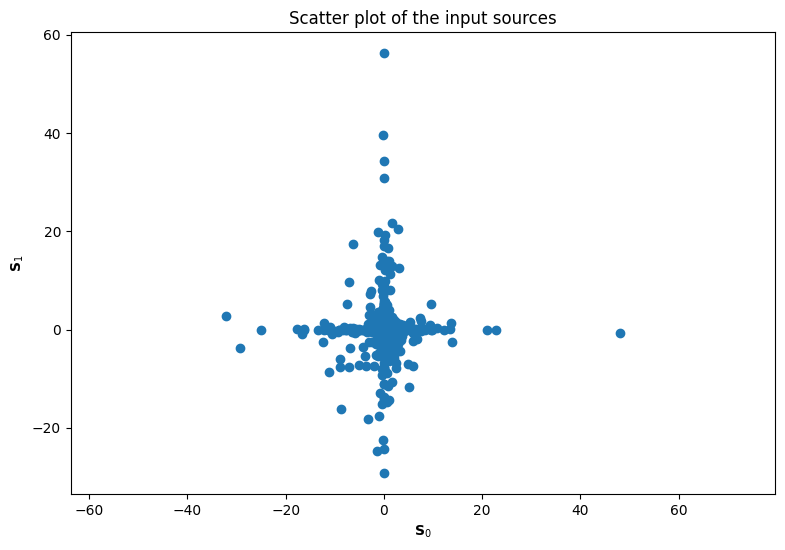

In [148]:
n = 2         # number of sources
t = 1024      # number of samples
noise_level = 80 # noise level, in dB
power = 3 # power exponent used in the source generation



# TO DO : generate a simulated source S matrix.
# S will be of dimensions n x t.
# Each of the n sources (i.e. lines of S) will follow the approximately sparse
# law we used above.
# S = np.zeros(n,t) # TO CHANGE
S = np.random.randn(n,t)**power

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

In [149]:
# Here, we generate a mixture matrix (dimensions m x t) from the sources in S
m = 4         # number of observations

A = np.random.randn(m,n)
X = A@S

noise_level = 120

# To be more realistic, we add some noise to the mixing.
# Mixtures with SNR > 120 dB can be considered as noiseless for most applications.
if noise_level < 120:
    #--- Add noise
    N = np.random.randn(m,t)
    N = 10.**(-noise_level/20.)*np.linalg.norm(X)/np.linalg.norm(N)*N
    X = X + N

Plot the scatter plot of X. What do you see ?

What do the directions of the lines you observe correspond ?

Try several A matrices, noise_values and powers. Any comment?


**Answer**:

It's possible to observe that the data points are now distributed along different directions.

Each one of the directions of the lines correspond to the signatures of the different endmembers presents in the signals . Each endmember contributes to the final observed data in a certain proportion defined by the mixing matrix A. In a noiseless situation, where we can recover the original signals.

So, changing the matrix A is equivalent to change the mixing proportions of the different endmembers of the combined signal. If we increase the noise the source separation task becomes more difficult, as well as indetifying the directions. Changing the power affects the distribution of the original sources; Higher power makes the source signals narrower.



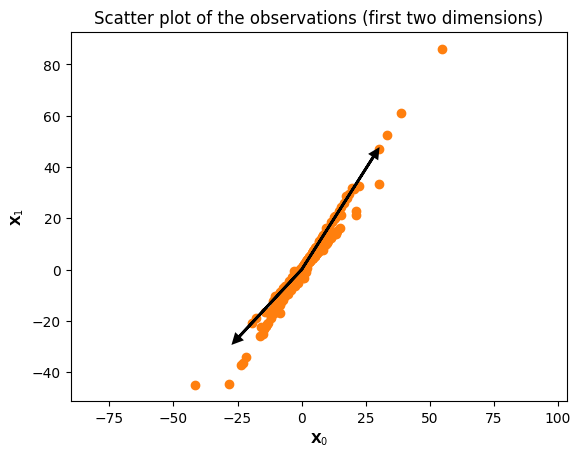

In [150]:
plt.title('Scatter plot of the observations (first two dimensions)')
vrange = 0.25*max(np.sqrt(np.sum(X*X, 0)))
plt.arrow( 0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow( 0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

**II - Performing non-blind source separation**

**1) Data generation**

Before going into blind source separation, in which we want to find physical **A** and **S** matrices such that **X = AS + N**, let us first consider the simpler setting in which we know **A** and want to recover **S**.
We will consider the noisy mixture of two sine signals. The methodology extends to more complex datasets.

N.B. : unmixing two sinus signal could be done much more easily than using the algorithms we saw during the class. Nevertheless, focusing on such synthetic data enables an easy visualization. The principle readily extend to more complex datasets, such as images.

(-25.0, 25.0)

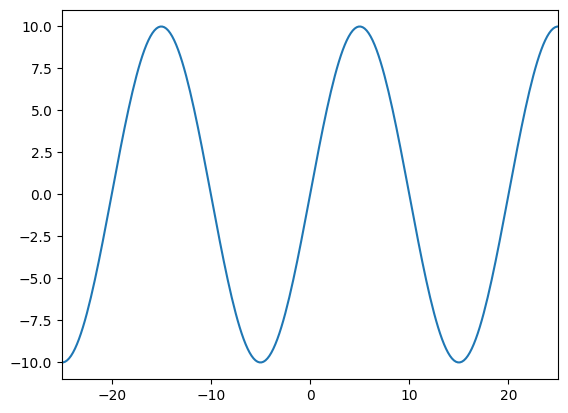

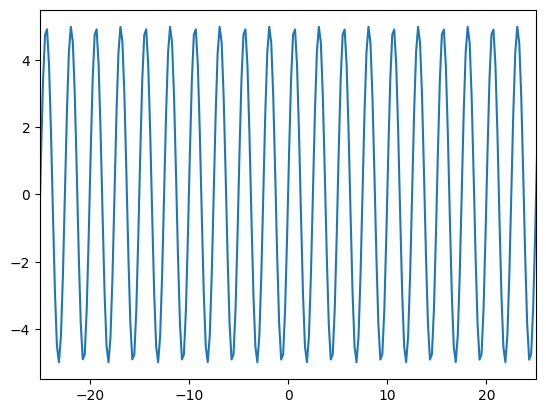

In [151]:
# Source generation
t = 10000
x_abs = np.linspace(-1000,1000,t)

S = np.zeros((2,t))
S[0,:] = 10*np.sin(2*np.pi*0.05*x_abs)
S[1,:] = 5*np.sin(2*np.pi*0.4*x_abs)

plt.figure(),plt.plot(x_abs,S[0,:])
plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs,S[1,:])
plt.xlim([-25,25])

Here, we will transform the sources signals S into the DCT domain.

What is the objective of using the DCT?

**Answer:** The point of using the Discrete Cosine Transform (DCT) is to represent a signal or data in a more compact form. This means that a signal that cannot be approximately sparse in the direct domain, can become sparse in the transformed domain.


Plot the above DCT and justify what you see. Pay attention to the labeling of the x-axis. Try with sines of various frequencies.

**Answer:**  When we apply DCT, the signals are decomposed into their constituent frequencies. Since the original signal are sinusoidals, the tranformed energy will be like a dirac function centered on their frequencies



(0.0, 0.5)

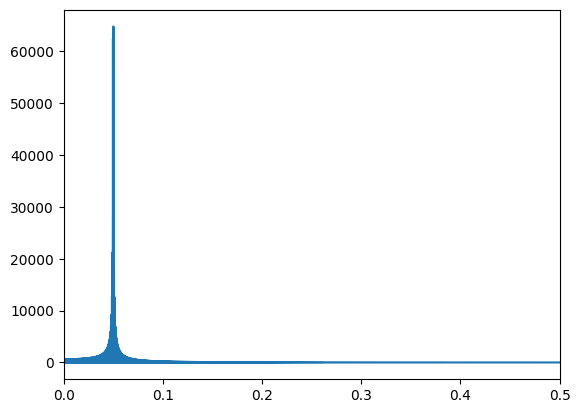

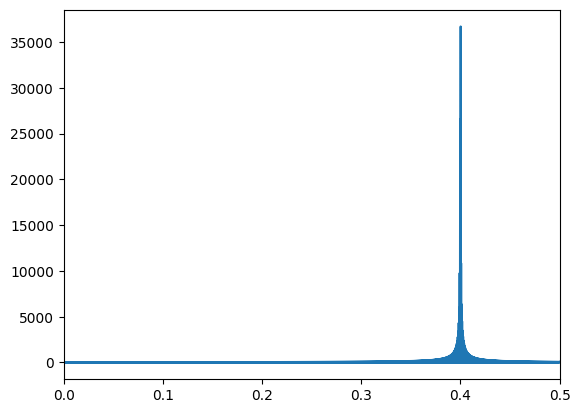

In [152]:
# Transformation into the DCT domain
Sf = sff.dct(S)

freq = np.arange(t) / (2 * (x_abs[-1] - x_abs[0]))

plt.figure()
plt.plot(freq, np.abs(Sf[0,:]))
plt.xlim(0, 0.5)
plt.figure()
plt.plot(freq, np.abs(Sf[1,:]))
plt.xlim(0, 0.5)


Data generation : now, we will create a mixture X = AS + N.

Plot the mixtures. Explain what you see.

Compute the DCT of X. Plot it and explain. Which caracteristic of the DCT will we use to recover the sources?

**Answer**: Again, the DCT of X shows peaks at the same frequencies as in the originals signals(0.05 and 0.4). But, due to the the mixing and the added noise, these peaks are less pronounced compared to the DCT of the original signals.

We can check some other small peaks, but they are less significant. So, once the DCT is able to separate the original frequqnecy of both signals, we recover the original sources frequencies, retaining information that is usefull for the  the source separation process.



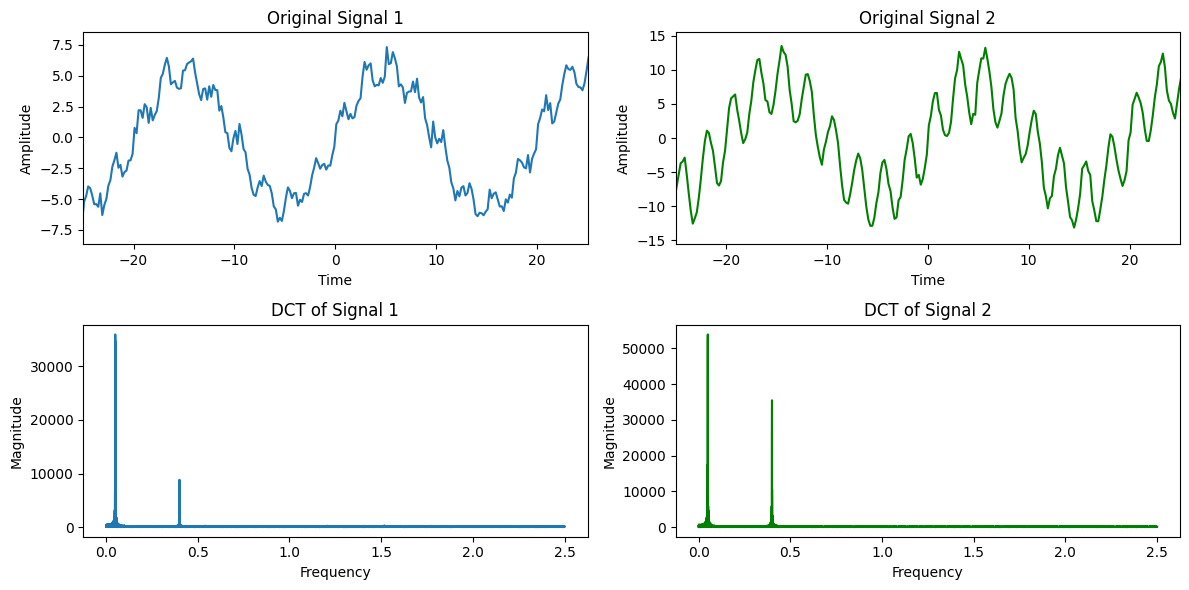

In [153]:

A = np.array([[0.5547002 , 0.24253563],
       [0.83205029, 0.9701425 ]]) # You can try other A values, but the columns must have a unitary norm.

X = A@S
X = X + 0.5*np.random.randn(np.shape(X)[0],np.shape(X)[1])# You can try other noise values

Xf = sff.dct(X)

plt.figure(figsize=(12, 6))

# Original Signals
plt.subplot(2, 2, 1)
plt.plot(x_abs, X[0,:])
plt.title("Original Signal 1")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.xlim([-25, 25])

plt.subplot(2, 2, 2)
plt.plot(x_abs, X[1,:],  color = 'g'),
plt.title("Original Signal 2")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.xlim([-25, 25])

# Frequency Domain (DCT)
plt.subplot(2, 2, 3)
plt.plot(freq, np.abs(Xf[0]))
plt.title("DCT of Signal 1")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.subplot(2, 2, 4)
plt.plot(freq, np.abs(Xf[1]), color = 'g')
plt.title("DCT of Signal 2")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.tight_layout()
plt.show()



**2) Source separation**

Now that we generated observations from simulated sources, we will focus on the source separation problem: recovering the sources from the observations (and the knowledge of A, since we are here in the non-blind setting).

To do that, we propose here to solve the source separation problem using a sparsity constraint on the sources. The cost function will then be minimized using the ISTA algorithm.

First, write the cost function we want to minimize to perform non-blind sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?

**Answer**: $ \text{argmin}_{A \in R^{m \times n}, S \in R^{m \times n}} \frac{1}{2} ||X - AS||_F^2 + \lambda ||S||_1 $

- Data Fidelity Term: $ \frac{1}{2} ||X - AS||_F^2 $ : It measures the discrepancy between the observed data X and the estimated data AS. The goal is to find an S such that AS is as close as possible to X. It's smooth and convex.

- Sparsity Term: $ \lambda ||S||_1 $ : It encourages the solution to be sparse. It's the L1 norm of S , weighted by a regularization parameter $\lambda$. The L1 norm promotes sparsity by effectively penalizying solutions with a lot of non-zero elements. This term is non-smooth, but it's convex.


Compute the gradient along the S variable of the data-fidelity term.
**Answer**:
To compute the gradient I will use the definition.

 we can express the gradient using the following expression:
$$f(x + h) =  f(x) + \langle ∇f(x), h \rangle + o(h) $$
Applying to this function we obtain:

$$f(S + h) = \frac{1}{2}||X -A(S+h) ||_F^2   = f(S) +  \langle X-AS, -Ah \rangle  + o(h) $$

But: $$  \langle X-AS, -Ah \rangle = hA^T(AS-X) = \langle A^T(AS-X), h \rangle$$

Then:
\begin{align*}
\nabla_S \frac{1}{2} ||X - AS||_2^F
&= A^T(AS-X)
\end{align*}


Recall what the proximal operator of the l1-norm is.

**Answer**:

$$ \text{prox}_{\lambda||\cdot||_1}(S)_i = \begin{cases}
s_i - \lambda & \text{if } s_i \geq \lambda \\
0 & \text{if } |s_i| \leq \lambda \\
s_i + \lambda & \text{if } s_i \leq -\lambda
\end{cases}  = \text{sign}(S_i) \cdot \max(|S_i| - \lambda, 0) $$





In [154]:
# TO DO: implement the proximal operator of the l1-norm in the above function:
def prox_l1(S_est,thrd):
#  # To complete
  return np.sign(S_est) * np.maximum(np.abs(S_est) - thrd, 0)

Explain the main idea of the ISTA algorithm. Then, implement it.

**Answer:** The Iterative Shrinkage-Thresholding Algorithm (ISTA) is a method designed to solve optimization problems that involve a convex, differentiable function plus a non-smooth, convex penalty term.

The way the algorithm does it is to apply iteratevely is to iteratively a  series of gradient descent step and and shrinkage operations,to estimate the sparse representation.


In [155]:
# TO DO: implement the ISTA algorithm to minimize the cost function you wrote in question II-2-1.
def ISTA(X, A=np.eye(2), n=2, lamb=0, nbIt=100):
    # Initialize S_est_0
    S_est = np.zeros((n, np.shape(X)[1]))

    gamma = 0.9/np.linalg.norm(A.T @ A)
    for k in range(nbIt):
        # Compute the gradient of the cost function
        grad = A.T @ (A @ S_est - X)

        # Update the estimate
        S_est = prox_l1(S_est - gamma*grad, lamb*gamma)

    return S_est

It's now time to play with the code : launch the ISTA algorithm and look at the results.

Try various lamb values. What is the minimum value you should no go below? What is the issue with choosing too big values?

**Answer**: In order to the regularization works properly must be $\lambda \geq 0$,in other case we would encourage the dense solutions.

We can check by the graphs below that while we increase lambda we encourage sparse energies. When we choose a $\lambda$ value really high, all the solutions tend to zero. On the other hand if $\lambda$ is too smallwe recover irregullar signals.



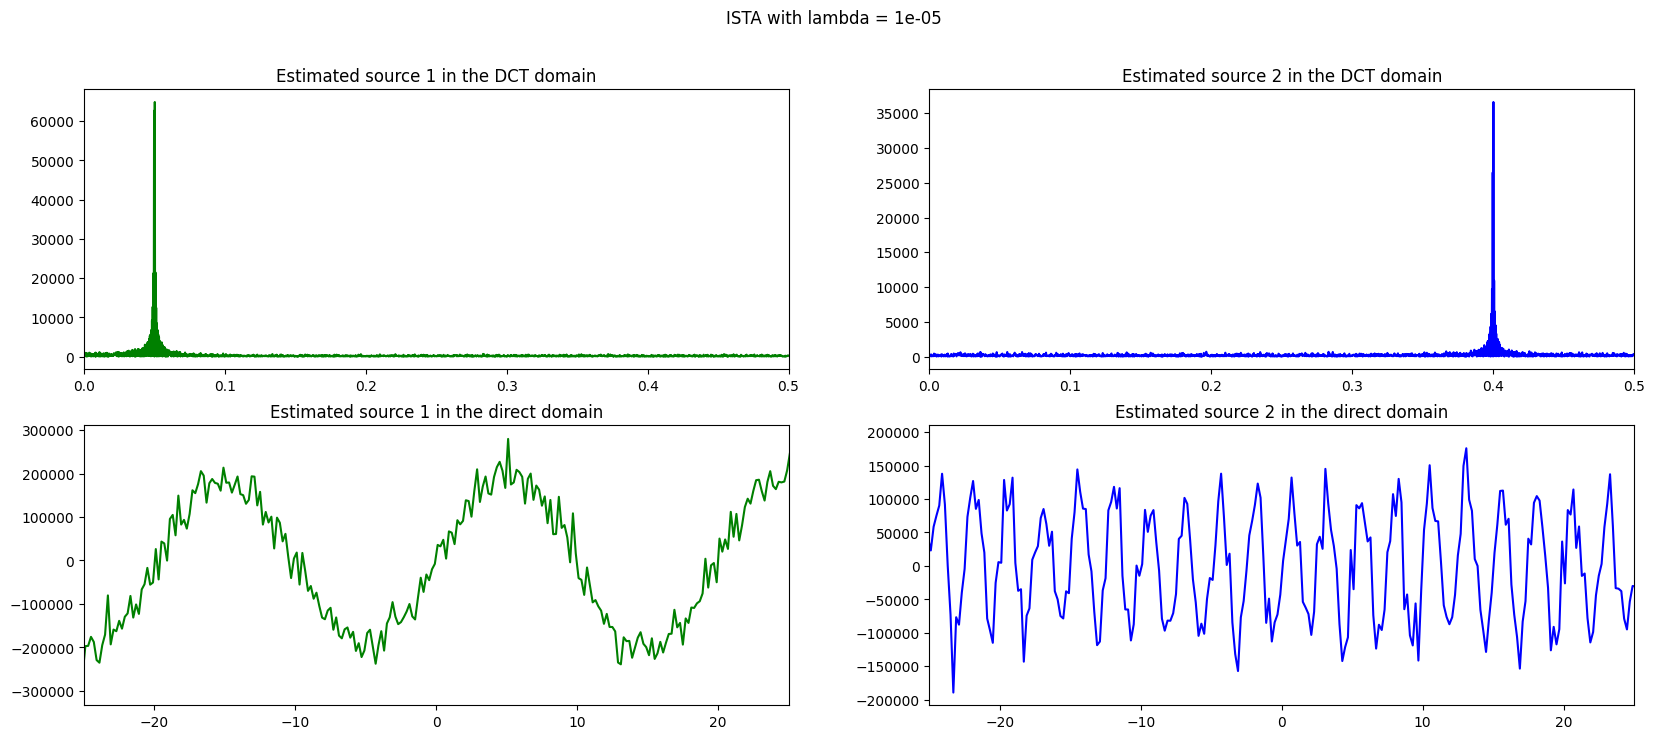

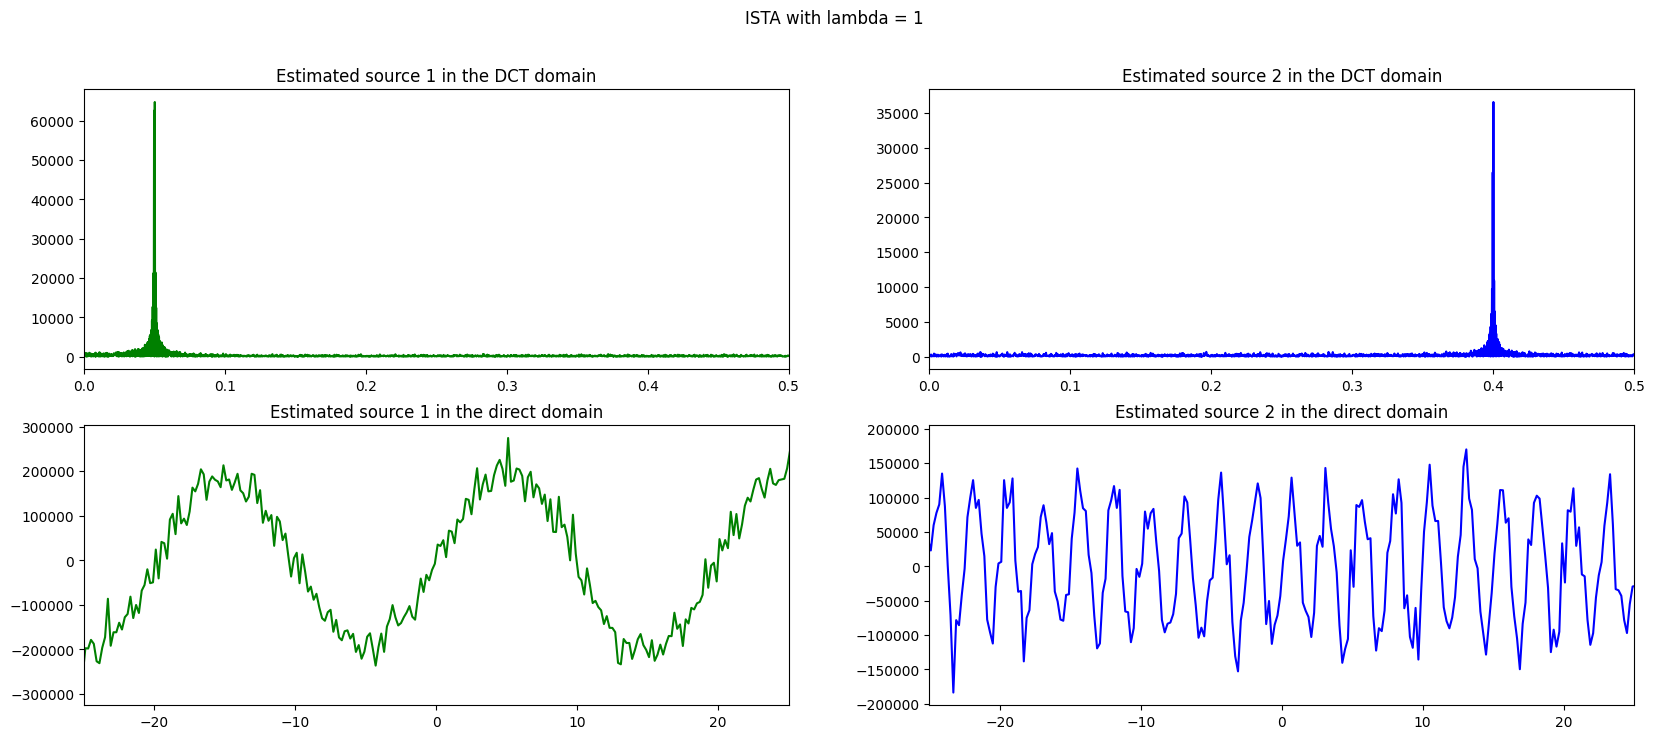

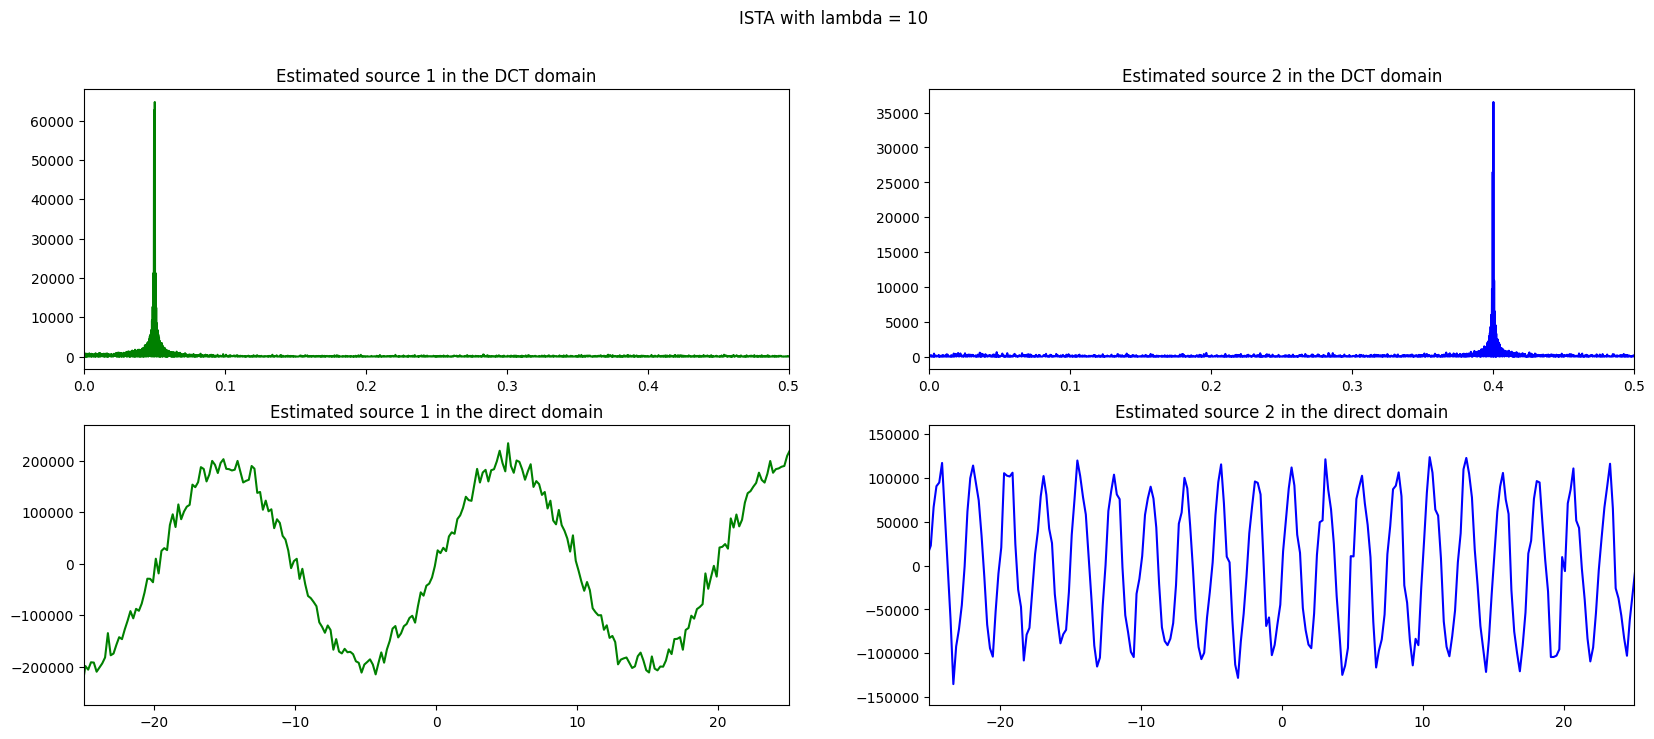

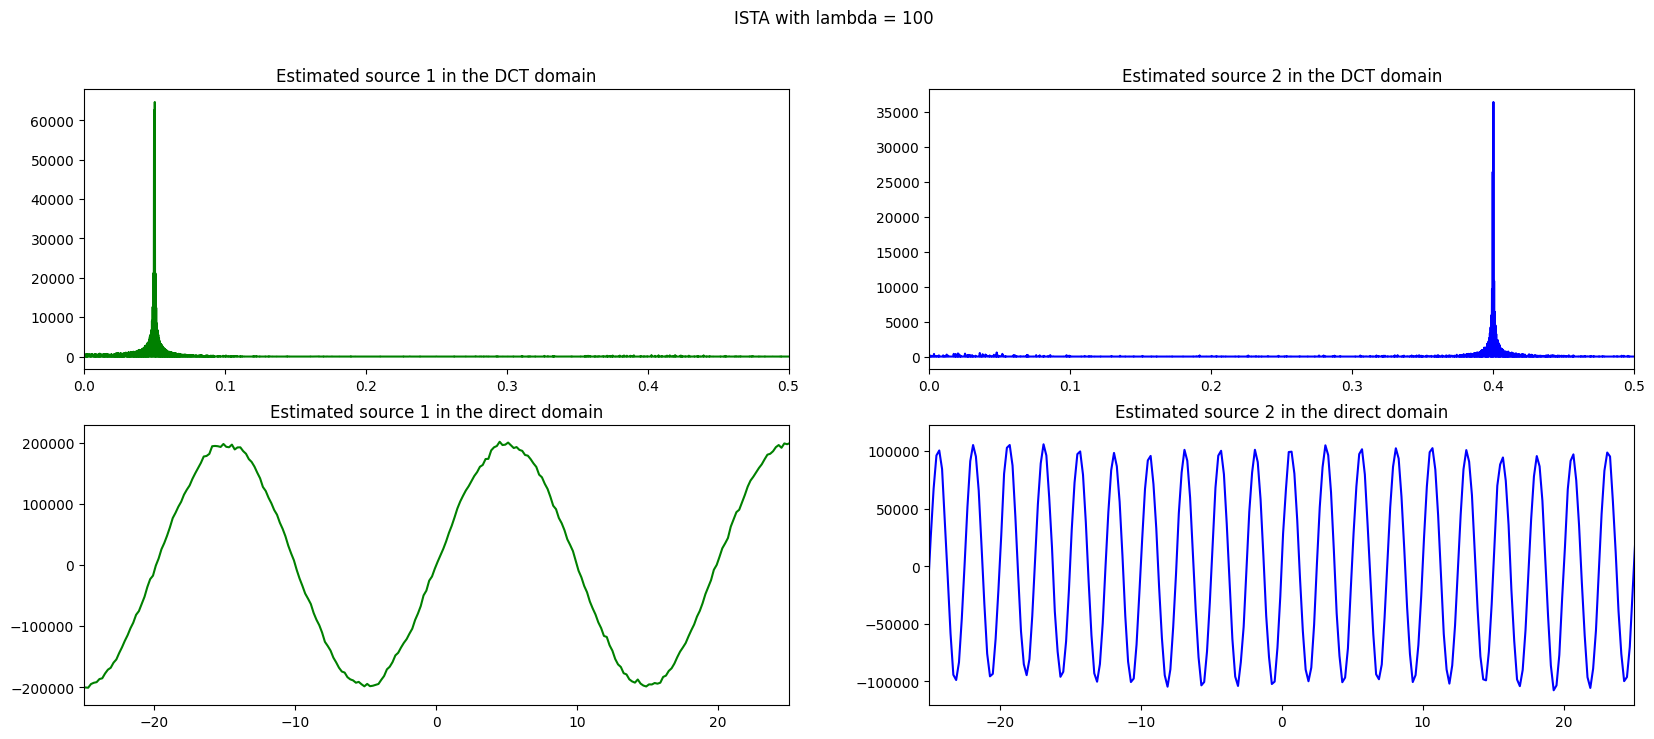

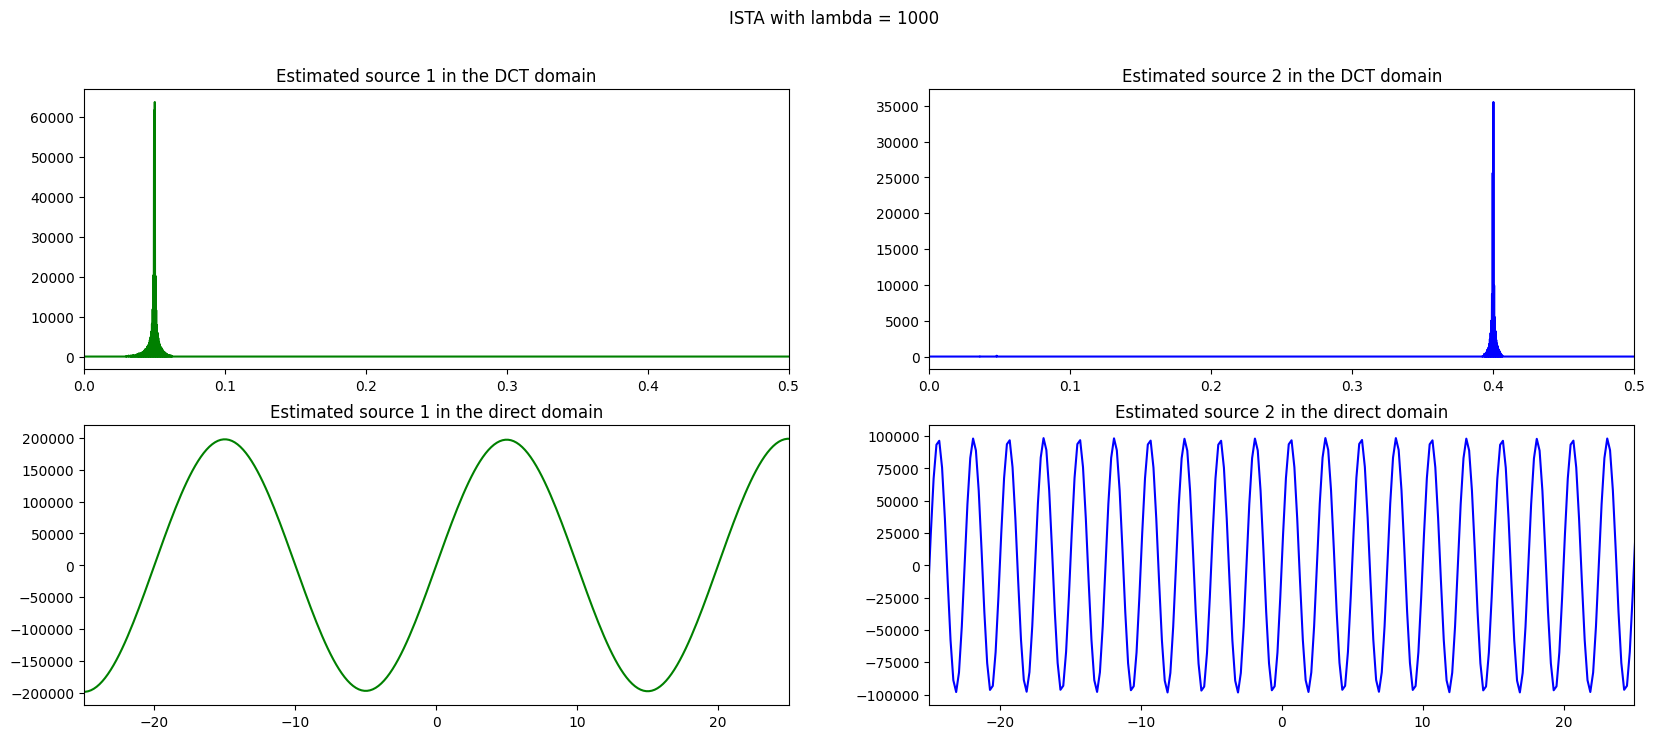

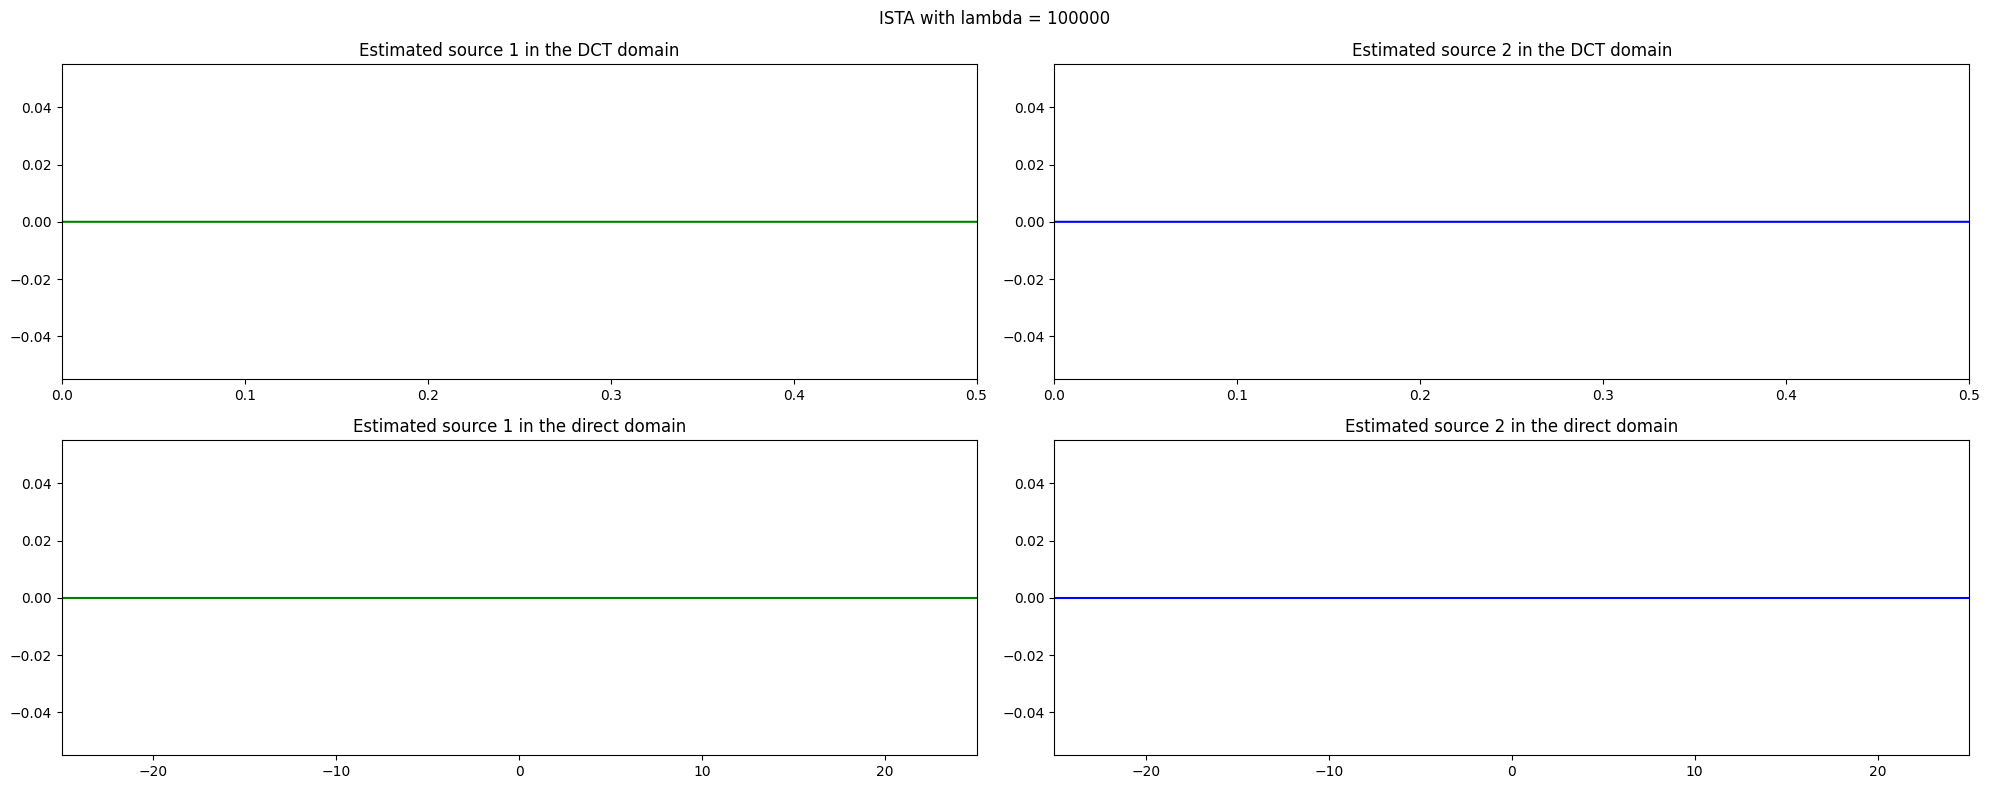

In [156]:
lbd = [0.00001, 1, 10, 100, 1000, 100000]



for i, lamb in enumerate(lbd):

    S_estf = ISTA(Xf, A=A, n=2, lamb=lamb, nbIt = 1000)
    fig, ax = plt.subplots(2, 2, figsize=(20, 8))
    fig.suptitle('ISTA with lambda = ' + str(lamb))

    ax[0, 0].plot(freq, abs(S_estf[0,:]), c='g')
    ax[0, 0].set_xlim([0, 0.5])
    ax[0, 0].set_title('Estimated source 1 in the DCT domain')

    ax[0, 1].plot(freq, abs(S_estf[1,:]), c='b')
    ax[0, 1].set_xlim([0, 0.5])
    ax[0, 1].set_title('Estimated source 2 in the DCT domain')
    S_est = sff.idct(S_estf)

    ax[1, 0].plot(x_abs, S_est[0,:], c='g')
    ax[1, 0].set_xlim([-25,25])
    ax[1, 0].set_title('Estimated source 1 in the direct domain')

    ax[1, 1].plot(x_abs, S_est[1,:], c='b')
    ax[1, 1].set_xlim([-25,25])
    ax[1, 1].set_title('Estimated source 2 in the direct domain')


plt.tight_layout()
plt.show()


Plot the estimated sources in the DCT domain. What kind of sparsity to they exhibit? Why?

**Answer**: Plotting the estimated sources in the DCT domain we can check that the signal are are approximately sparse, concentrated in the original frequencies of the original frequencies of the signals, because of the properties of the of DCT.

Transform the sources back in the direct domain. Plot them. What do you see? Explain the differences with the original sources. Conclude.

**Answers**: The results are really good. The only difference is that it increases a lot the amplitude of the signal.

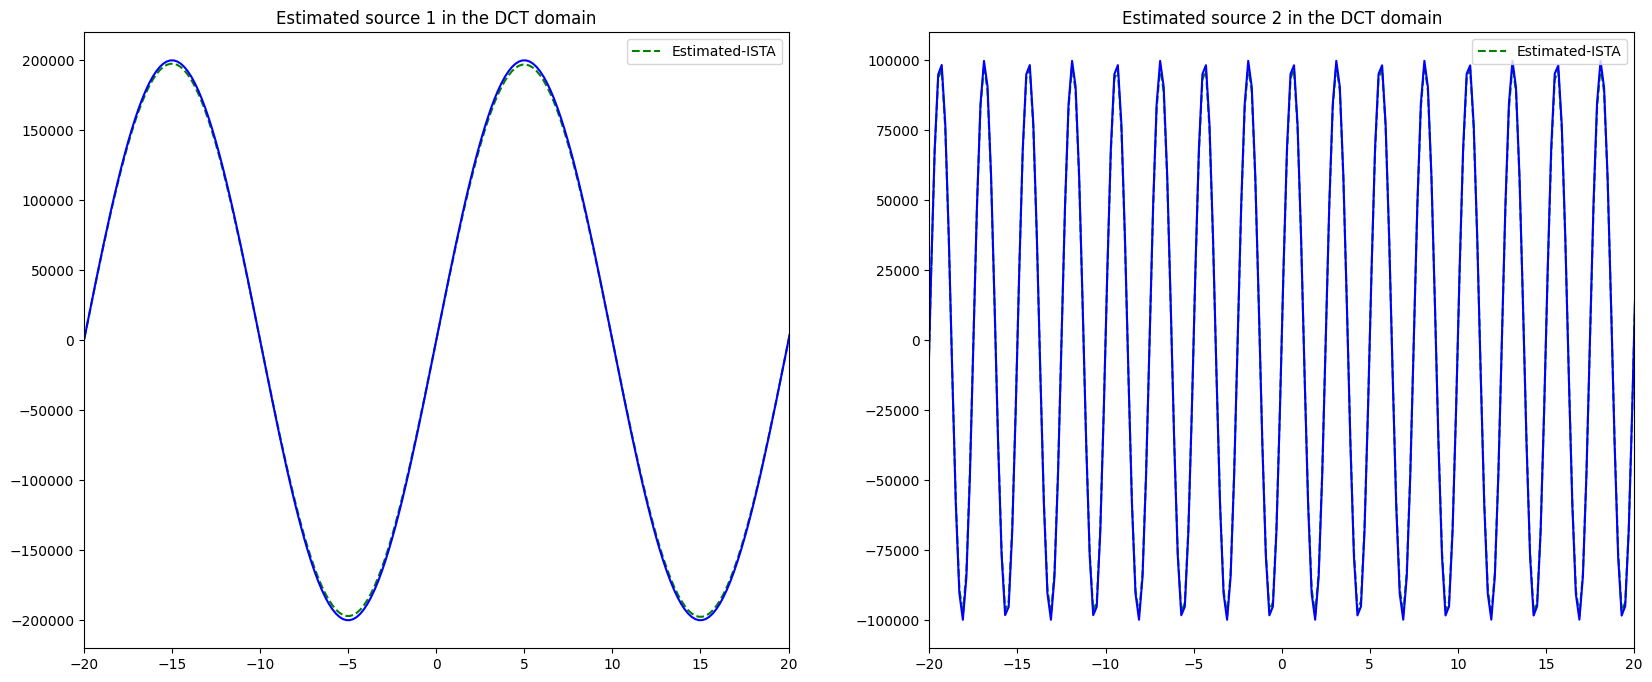

In [157]:
S_estf = ISTA(Xf, A=A, n=2, lamb=1000, nbIt = 1000)
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
S_est = sff.idct(S_estf)

ax[0].plot(x_abs, S_est[0,:], c='g', linestyle = '--', label='Estimated-ISTA')
ax[0].plot(x_abs, S[0,:]*20000, c='b')
ax[0].set_xlim([-20, 20])
ax[0].set_title('Estimated source 1 in the DCT domain')
ax[0].legend()


ax[1].plot(x_abs, S_est[1,:], c='g', linestyle = '--', label='Estimated-ISTA')
ax[1].plot(x_abs, S[1,:]*20000, c='b')
ax[1].set_xlim([-20, 20])
ax[1].set_title('Estimated source 2 in the DCT domain')
ax[1].legend()


**III - Blind Source Separation : PALM**

Let's now delve into the core problem : *blind* source separation, in which **A** is unknown. To leverage sparsity, we will use the PALM algorithm.

Thoughout this whole section, we will re-use the same synthetic data as above (i.e., the one generated in II-1).

Write the cost function we want to minimize to perform *blind* sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?

**Answer**:

$$ \text{argmin}_{A \in R^{m \times n}, S \in R^{m \times n}} \frac{1}{2} ||X - AS||_F^2 + \lambda ||S||_1 + \iota_{ {i \in [1,n]; ||a_{i,j}||l_{2}^2 \leq 1 }}(A) $$

As before
- Data Fidelity Term: $ \frac{1}{2} ||X - AS||_F^2 $ : It measures the discrepancy between the observed data X and the estimated data AS. The goal is to find an S such that AS is as close as possible to X. It's smooth and convex.

- Sparsity Term: $ \lambda ||S||_1 $ : It encourages the solution to be sparse. It's the L1 norm of S , weighted by a regularization parameter $\lambda$. The L1 norm promotes sparsity by effectively penalizying solutions with a lot of non-zero elements. This term is non-smooth, but it's convex.


- Oblique constraint $\iota_{ {i \in [1,n]; ||a_{i,j}||l_{2}^2 \leq 1 }}(A) $ : This constraint forces the columns of the mixing matrix A to have a unit norm, which means that each column vector has a length or magnitude of 1. Without constraints, the problem would have an infinite number of solutions because any scaling of the sources can be counterbalanced by an inverse scaling of the mixing matrix. This function is convex but not smooth, because of it's discontinuity.


So we will have to use a more sophisticated method to optmize this functio: proximal operator





Recall what the gradient of the data fidelity term over A is.

In a similar procedure of the question in the section 2, we can arrive at:

$$ \nabla_A \frac{1}{2} ||X - AS||_F^2 = S^T(AS-X) $$


Compute the proximal operator of the oblique constraint. Implement it.

**Answer:**


Using the definition of proximal operator:

$$
\textit{prox}_{\iota_C} (s) = \text{argmin}_{y \in \mathbb{R}^n} \,\, \iota_C(y) + \frac{1}{2} \|s - y\|_{\ell^2}^2
$$

So:

$$
\textit{prox}_{\iota_C} (s) = \text{argmin}_{y \in C} \,\, \frac{1}{2} \|s - y\|_{\ell^2}^2 =
$$

which is nothing but the Euclidean projection of $s$ onto $C$. Then:

$$
\textit{prox}_{\iota_C} (A) = \text{argmin}_{M \in C} \,\, \frac{1}{2} \|A - M\|_{\ell^2}^2  = \text{Proj}_C(A)
$$

with $C = {\left\{ \forall i \in [1,n]; \left\| m_{:, j} \right\|_{\ell_2}^2 \leq 1 \right\}}$. In another words, $M$ is the Euclidian  projection of A into the onto the unit ball.



In [158]:
def prox_oblique(A):
    # TO DO
    for j in range(A.shape[1]):
      if np.linalg.norm(A[:, j]) > 1:
        A[:, j] /= np.linalg.norm(A[:, j])
    return A

Implement the PALM algorithm to minimize the cost function you wrote in III-1).

In [159]:
random_state = 42
def PALM(X, n=2, lamb=0, nbIt=100, random_state =0):
    # Initialize A_est and S_est
    m, t = X.shape
    np.random.seed(random_state)
    A_est = np.random.randn(m, n)
    S_est = np.random.randn(n, t)

    # Iterate for nbIt iterations
    for _ in range(nbIt):
         # Update S_est
        S_est = prox_l1(S_est + 0.9/np.linalg.norm(A_est.T @ A_est) * A_est.T @ (X - A_est @ S_est), lamb)

        # Update A_est
        A_est = prox_oblique(A_est + 0.9/np.linalg.norm(S_est @ S_est.T) * (X - A_est @ S_est) @ S_est.T)

    return A_est, S_est

Launch the PALM algorithm to retrieve both A and S from X. Plot your results. How good is the separation? The separation quality is usually well evaluated comparing the true and estimated A matrices.

The results depends highly of `nbIt` and `lamb`;

If the value of `lamb` or`nbIt` is too low we get a linear combination of sinoids in the time domain.

Again if `lamb` is too high, we have problems in the estimatio, and we do not recover the signals.



In [160]:
A_est, S_estf = PALM(Xf, n=2, lamb=6000, nbIt=1000, random_state=0)

print(f'A = \n{A}\n')
print(f'A_1 = \n{A_est}\n')

A = 
[[0.5547002  0.24253563]
 [0.83205029 0.9701425 ]]

A_1 = 
[[0.55493421 0.24256473]
 [0.83189424 0.97013522]]



Text(0.5, 1.0, 'Estimated source 2 in the direct domain')

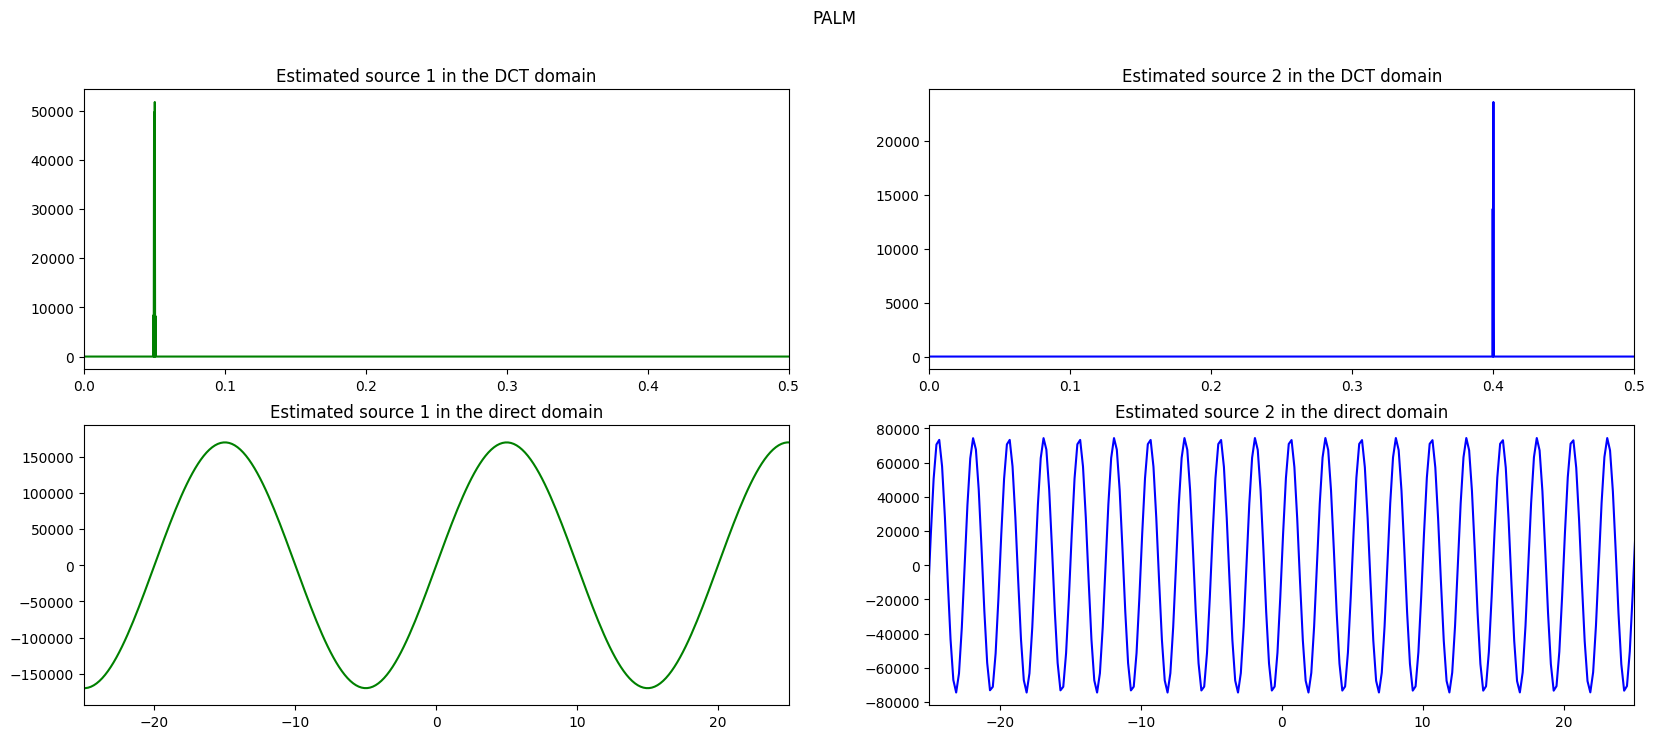

In [161]:

fig, ax = plt.subplots(2, 2, figsize=(20, 8))
fig.suptitle('PALM')

ax[0, 0].plot(freq, abs(S_estf[0,:]), c='g')
ax[0, 0].set_xlim([0, 0.5])
ax[0, 0].set_title('Estimated source 1 in the DCT domain')

ax[0, 1].plot(freq, abs(S_estf[1,:]), c='b')
ax[0, 1].set_xlim([0, 0.5])
ax[0, 1].set_title('Estimated source 2 in the DCT domain')


S_est = sff.idct(S_estf)

ax[1, 0].plot(x_abs, S_est[0,:], c='g')
ax[1, 0].set_xlim([-25,25])
ax[1, 0].set_title('Estimated source 1 in the direct domain')

ax[1, 1].plot(x_abs, S_est[1,:], c='b')
ax[1, 1].set_xlim([-25,25])
ax[1, 1].set_title('Estimated source 2 in the direct domain')

